# Donkey Car Default CNN (Control Experiment)

## Default CNN Setup against which all other models developed in this project will be compared to as a baseline

This Default CNN will be the 'minimum required functionality' design - just small enough to make predictions without overfitting to its own training data (when comparing validation and training loss)


The metrics that will be logged throughout all experiments will be training loss, validation loss, and prediction loss and accuracy. The parameters and factors logged will be the number of epochs, the layers, the batch size, the normalization and pruning used (if applicable) and the datasets used and their characteristics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Step 1: Dataset Retrieval and Management
The Dataset used for this experiment is found in the mounted Google Drive folder (if not mounted, contact me and we can try sort it out). The dataset consists of images, and json labels for those images. The json labels contain the driving angle as floating point values in the range of -1 and 1. -1 means all the way left, and 1 means all the way to the right. We are not addressing throttle labels in this experiment. 


In [ ]:
#Mount Data Folder From Google Drive:

#path = "/content/drive/My Drive/DIYRobocars_2020/Data/halldatarecords2/"
path = "./Documents/DonkeyCar/SimDataGenTrack1/"
#path = "./Documents/DonkeyCar/SimDataWHCounterClockwise/"

In [ ]:
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataGenTrack1.zip'
#!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataWHClockwise.zip'
#!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataWHCounterClockwise.zip'

In [ ]:
#Import required packages for this step:

import os   #For retrieving files
import natsort #For sorting retrieved files
import numpy as np #Calculations, arrays, etc.
import cv2 #Image preprocessing, loading and saving images
import json #For processing json files
import tensorflow as tf  #For the ML side
from random import randrange 

import matplotlib.pyplot as plt #Plots


#Make sure plots happen inline


%matplotlib inline

In [ ]:
#Read data from files into corresponding lists
#You may need to run this cell several times - colabs connection to Drive times 
#out if the number of files to retrieve get too large. If this is the case, run
#it a few times until it works. Colab caches files already retrieved in the last run,
#so rerunning it several times will eventually get all the files read. Clumsy, but
#don't shoot the messenger. Their docs themselves say this.
%%time

im_list = [] #initialise list of images

rec_list = [] #initialise list of records

#Read relevant files into relevant lists

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

print(len(im_list))
print(len(rec_list))

15061
15061
CPU times: user 11.2 ms, sys: 16.1 ms, total: 27.2 ms
Wall time: 28.6 ms


(15061, 120, 160, 3)
(15061,)
0.0


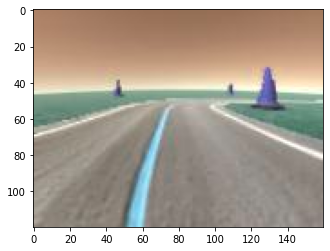

CPU times: user 16.3 s, sys: 7.37 s, total: 23.6 s
Wall time: 28.1 s


In [ ]:
%%time

#Import Image from Pillow
from PIL import Image
#THIS TAKES ABSOLUTELY FOREVER TO RUN I AM SORRY - maybe try to copy paste zip file from drive to colab and work from there?
#Sort data lists and split into data and labels

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

#Initialise images array:

x_images = np.zeros((len(rec_list), width, height, color), dtype = np.float32)

print(x_images.shape)
#Read images into images array
for i in range(len(im_list)):
    filename = im_list[i]
    image = cv2.imread(path+filename)
    x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors

#read angle labels into y_labels array
json_data = {}
y_labels = np.zeros(len(rec_list), dtype=np.float32) #setup label array 
print(y_labels.shape)
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_labels[i] = orient

randomImage = randrange(len(x_images)) #Get an index for a random image to show to ensure data read correctly
print(y_labels[randomImage])
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show() #Show Image

0.19998672066927828


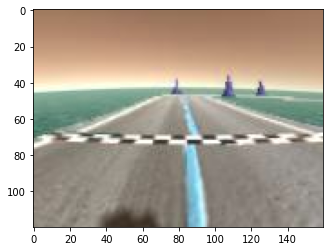

0.0


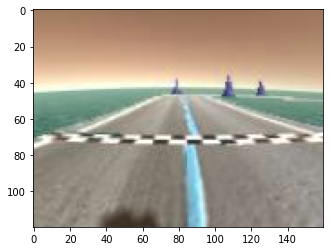

In [ ]:
#Donkey Training and Val data splits

def train_test_split(data_list,label_list, shuffle=True, test_size=0.2):
    '''
    take a list, split it into two sets while selecting a 
    random element in order to shuffle the results.
    use the test_size to choose the split percent.
    shuffle is always True, left there to be backwards compatible
    '''
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    train_data = []
    train_labels =[]

    target_train_size = len(data_list) * (1. - test_size)

    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        train_labels.append(label_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the validation set
    val_data = data_list
    val_labels = label_list
    return val_data, train_data, val_labels, train_labels

x_val, x_train, y_val, y_train = train_test_split(x_images,y_labels)

print(len(x_val)/len(x_images))

plt.imshow(x_train[1000].astype('uint8'))
plt.show()
print(y_train[1000])
x_val = np.asarray(x_val)/255 #Images best practices
y_val = np.asarray(y_val)
x_train = np.asarray(x_train)/255
y_train = np.asarray(y_train)


plt.imshow(x_train[1000])
plt.show()

(15044,)
700
1700
2700
3700
4700
5700
6700
7700
8700
9700
10700
11700
12700
13700
14700


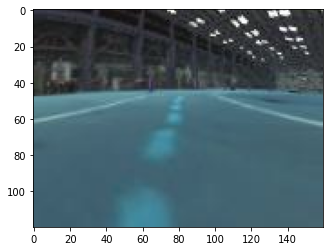

0.0


In [ ]:
#DO NOT RUN

#Create training and validation splits

memv = 0
memt = 0



x_val = np.zeros((round(len(x_images)*0.3)+1,width, height, color), dtype=np.float32)
x_train = np.zeros((round(len(x_images)*0.7)+1,width, height, color), dtype=np.float32)
y_val = np.zeros((round(len(x_images)*0.3)+1), dtype=np.float32)
y_train = np.zeros((round(len(x_images)*0.7)+1), dtype=np.float32)

n=0
print(y_labels.shape)

#Extract the last 300 of every 1000 images and records as validation data

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j)
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            #x_val[l] = x_images[j+o,:,:,:]
            x_val[l] = x_images[j+o,:,:,:]
            y_val[l] = y_labels[j+o]
            o +=1
        for m in range(0+n*700, n*700+700):
            #x_train[m] = x_images[k+p,:,:,:]
            x_train[m] = x_images[k+p,:,:,:]
            y_train[m] = y_labels[k+p]
            p+=1
        n+=1

#Show an image in the validation set

plt.imshow(x_val[1000].astype('uint8'))
plt.show()
print(y_val[1000])
print(y_val.shape)

### Step 2: Set up Bare-Bones Network

This CNN network consists of a few convolutional and pooling layers, and one or two dense layers. For now, we are trying a regression output. Comparisons between categorical and regression networks may be tested at a later stage.

This is also where the Neptune experiment setup begins. This will follow mostly the same style as found in the Donkey Toy Experiment notebook. The Neptune experiment tracker for the littlefoot project can be found at https://ui.neptune.ai/charag/Littlefoot/experiments?viewId=standard-view. Currently, we are tracking the validation loss and accuracy of the default setup, and are comparing variations in layer amounts, layer sizes, kernel sizes, and other parameters that will be listed. 

This experiment will focus on getting a basic CNN to reliably predict an action with familiar data better than randomly predicting an action (randomly prediciting an action will be tried out and described at a possible later date). Once this is done, the next experiment set (in a coming notebook) will detail an effort to improve validation loss and accuracy on unfamiliar data using generalisation techniques such as dropout, pruning, varying activations etc.


This experiment set will be tagged DefaultCNN in Neptune. Versioning of notebooks for each experiment will still be detailed.

In [ ]:
import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTgyNzBkM2EtMzZhNC00NDkwLWJiNmEtNDJiYzQ0ZDRjZWNkIn0='

In [ ]:

#Neptune experiment initialization:
try:
   import neptune
except:
  !pip install neptune-client
  import neptune
#Import neptune and initialise tracking of an experiment

neptune.init(
    api_token=None,
    project_qualified_name="charag/Littlefoot"
) #API Token is set to environment variable and the project name littlefoot is selected


#Enable logging in a neptune experiment - define keras callbacks and create a neptune logger class

from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}): #Log metrics after every batch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}): #log metrics after every epoch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)


#Experiment Parameters:

OPTIMIZER = 'adam' #stochastic gradient descent
LOSS = 'mse' #absolute error from the value desired
#LOSS = 'mae'
EPOCH = 300
BATCH = 132
KERNEL1 = 5
KERNEL2 = 3
STRIDE = 2
CONVLAYERS = 6
DENSELAYERS = 4
POOLLAYERS = 1
PRUNING = "dropout"

In [35]:
#Start Experiment:
neptune.create_experiment(name='Base CNN Build',
                          params={'epochs': EPOCH,
                                  'batch_size': BATCH,
                                  'Convolutional Layers': CONVLAYERS,
                                  'Dense Layers': DENSELAYERS,
                                  'Pooling Layers': POOLLAYERS,
                                  'Optimization' : OPTIMIZER,
                                  'LOSS': LOSS},         
                          tags=['Base_CNN_Build', 'Dropout'],
                          description="Dropout Layers after every Convolutional Layer (15% Drop), MSE used"
                          )


https://ui.neptune.ai/charag/Littlefoot/e/LIT-136


Experiment(LIT-136)

In [36]:
# Imports: Tensorflow 1.14.0 is used
import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, Convolution1D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda


In [34]:
#Model Structure Setup:
drop = 0.10
model = Sequential()

model.add(Convolution2D(12, (3,3), strides=(2,2), activation='relu', input_shape=(120,160,3)))
model.add(Convolution2D(24, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(drop))
model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(drop))
model.add(MaxPooling2D(3,1,padding='valid'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(drop))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(Dropout(drop))
model.add(Convolution2D(128, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(drop))

model.add(Flatten())
#model.add(Reshape((1,768))
#model.add(Conv1D(32, 3, strides=1,activation='relu'))

model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
#model.add(Dropout(drop))
model.add(Dense(250, activation='relu'))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(drop))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear')) #Regression Output

In [ ]:
#Donkeycar Standard Regression Model
drop = 0.1
model = Sequential()
model.add(Input(shape=(120,160,3), name='img_in'))
model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1"))
model.add(Dropout(drop))
model.add(Convolution2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2"))
model.add(Dropout(drop))
model.add(Convolution2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3"))
model.add(Dropout(drop))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_4"))
model.add(Dropout(drop))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5"))
model.add(Dropout(drop))
    
model.add(Flatten(name='flattened'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(50, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(1,activation='linear'))

In [37]:
#Compile Model 
model.compile(optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 59, 79, 12)        336       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 29, 39, 24)        2616      
_________________________________________________________________
dropout_21 (Dropout)         (None, 29, 39, 24)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 19, 32)        6944      
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 19, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 17, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 5, 8, 64)         

In [38]:
#Fit Model to Data
EarlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
save_best = keras.callbacks.ModelCheckpoint('Lit.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#model.fit(x_fit, y_fit, epochs=EPOCH, batch_size=1, validation_data=(x_fit, y_fit),callbacks=[NeptuneLogger()], shuffle=True, verbose=1)

model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)

#model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), save_best], shuffle=True, verbose=1)
#Stop Neptune Experiment:

neptune.stop()

Epoch 1/300
91/92 [============================>.] - ETA: 0s - loss: 0.2852 - accuracy: 0.5756
Epoch 00001: val_loss improved from inf to 0.10923, saving model to Lit.h5
92/92 [==============================] - 5s 56ms/step - loss: 0.2848 - accuracy: 0.5761 - val_loss: 0.1092 - val_accuracy: 0.7523
Epoch 2/300
91/92 [============================>.] - ETA: 0s - loss: 0.0928 - accuracy: 0.7603
Epoch 00002: val_loss improved from 0.10923 to 0.06542, saving model to Lit.h5
92/92 [==============================] - 4s 45ms/step - loss: 0.0928 - accuracy: 0.7606 - val_loss: 0.0654 - val_accuracy: 0.7865
Epoch 3/300
91/92 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.7822
Epoch 00003: val_loss improved from 0.06542 to 0.05969, saving model to Lit.h5
92/92 [==============================] - 4s 46ms/step - loss: 0.0654 - accuracy: 0.7824 - val_loss: 0.0597 - val_accuracy: 0.7908
Epoch 4/300
91/92 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.78

## STEP 3: Validate Your Model
After the experiment has completed, select a random image/label pair with which to run a prediction, or even a set of these predictions, to have a tangible vision of how the model performs.

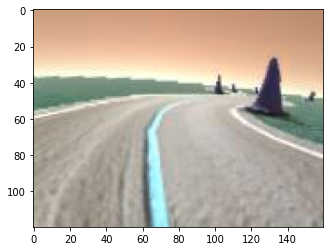

Label:
1.0
23/23 [==============================] - 1s 22ms/step - loss: 0.0129 - accuracy: 0.8134
result:
[1.0009439]
0.044191387646329426
0.9558086123536705
0.04419138764632946


In [39]:
num = randrange(len(x_val))

#Select Random Image and Label to show as examples
plt.imshow(x_val[num])
plt.show()

pred_im = x_val[num]
pred_label = y_val[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_val))
perc = np.zeros(len(y_val))

ModelBest = keras.models.load_model('Lit.h5')

#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x_val, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x_val, y_val, batch_size=BATCH, verbose=1)

for i in range(0, len(y_val)):
  diff[i] = abs(y_val[i] - label_out[i])
  perc[i] = (np.max(y_val)-diff[i])/np.max(y_val)
#model.save('LIT-16.h5')
print("result:")
print(label_out[num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))